In [127]:
# Configurations
DATASET = "sample_data.xlsx"
DATASET_SHEET = "Sheet1"
QUESTION_DEFINITIONS = "question_definitions.xlsx"
QUESTION_DEFINITIONS_SHEET = "Sheet1"
ADDITIONAL_STOP_WORDS = ["nil"]
WORD_FREQUENCIES_TOP = 3

In [128]:
from operator import itemgetter
from IPython.core.display import display, HTML
import re
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import figure

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
stopWords = set(stopwords.words("english"))

# matplotlib Configurations
params = {
    'figure.figsize': (15, 12),
    'font.size': 16
}
plt.rcParams.update(params)

def create_graph(x, y, title="", xlabel="", ylabel= "", type=""):
    fig, ax = plt.subplots()
    
    if type == "bar":
        ax.bar(x, y)
    else:
        ax.plot(x, y)
    
    ax.set_title(title, pad=50)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Ensure that x-axis is an integer where applicable
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # Ensure that y-axis is an integer where applicable
    # Hide the top and right borders
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # Show the values on top of the point / bar
    for i, v in enumerate(y):
        ax.text(i, v + .05, str(v), ha='center', va='bottom')
    plt.show()
    
def html_print(text):
    display(HTML(text))
    
def generate_word_list(s):
    processed_wordlist = []
    # Convert string to lowercase
    s = s.lower()
    wordlist = s.split()
    for word in wordlist:
        # Avoid processing stop words
        if word not in stopWords and word not in ADDITIONAL_STOP_WORDS:
            # Remove symbols
            word = re.sub(r'[^\w]', " ", word)
            processed_words = word.split()
            for w in processed_words:
                # Not adding words with only one alphabet
                if len(w) > 1:
                    processed_wordlist.append(w)
    return processed_wordlist

def word_frequencies(wordlist):
    wordfreq = []
    for w in wordlist:
        wordfreq.append(wordlist.count(w))

    result = list(zip(wordlist, wordfreq))
    # Remove duplicates
    result = list(dict.fromkeys(result))
    # Sort the list
    result = sorted(result, key=lambda x:x[1], reverse=True)
    if len(result) > WORD_FREQUENCIES_TOP:
        return result[:WORD_FREQUENCIES_TOP]
    else:
        return result

def process_tuples(t):
    return sorted(t, key=lambda k: k[1], reverse=True)

def word_frequency_graph(wf, graph_title):
    x, y = zip(*process_tuples(wf))
    create_graph(x, y, graph_title, "Word", "Count", "bar")

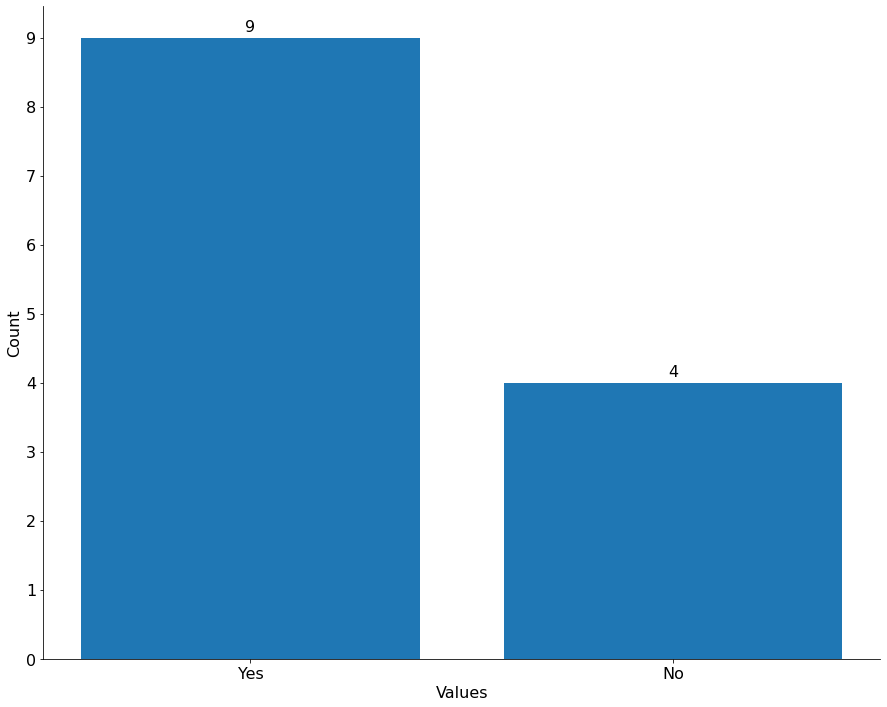

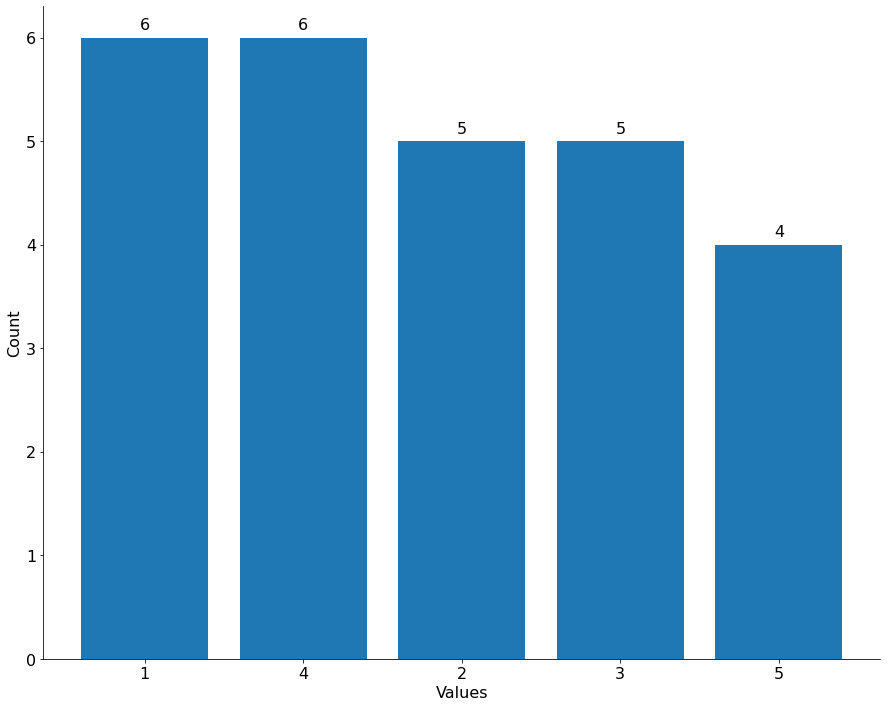

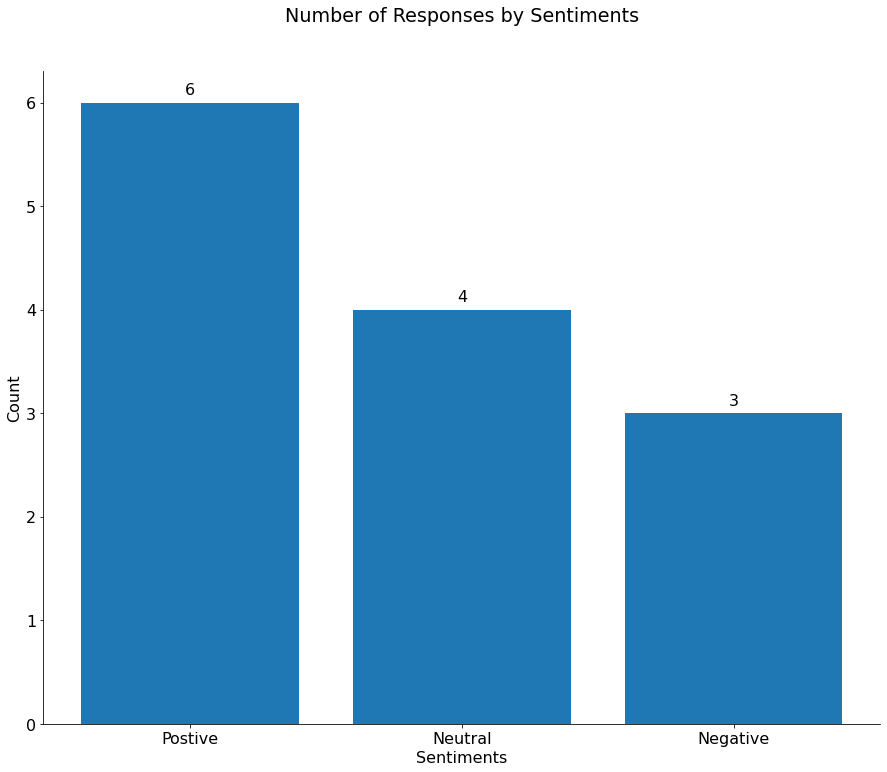

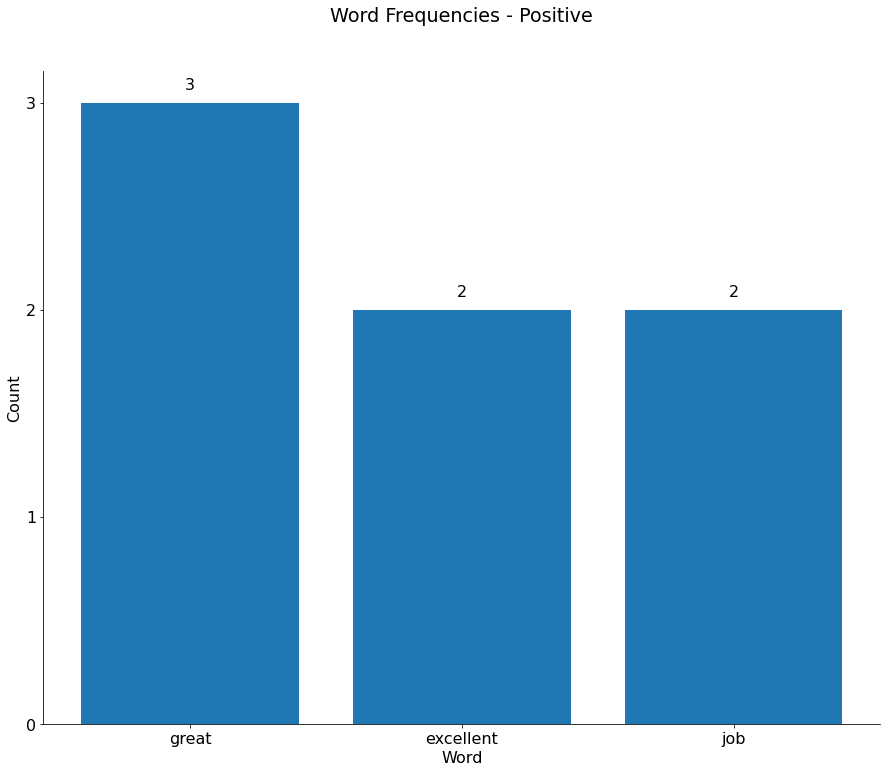

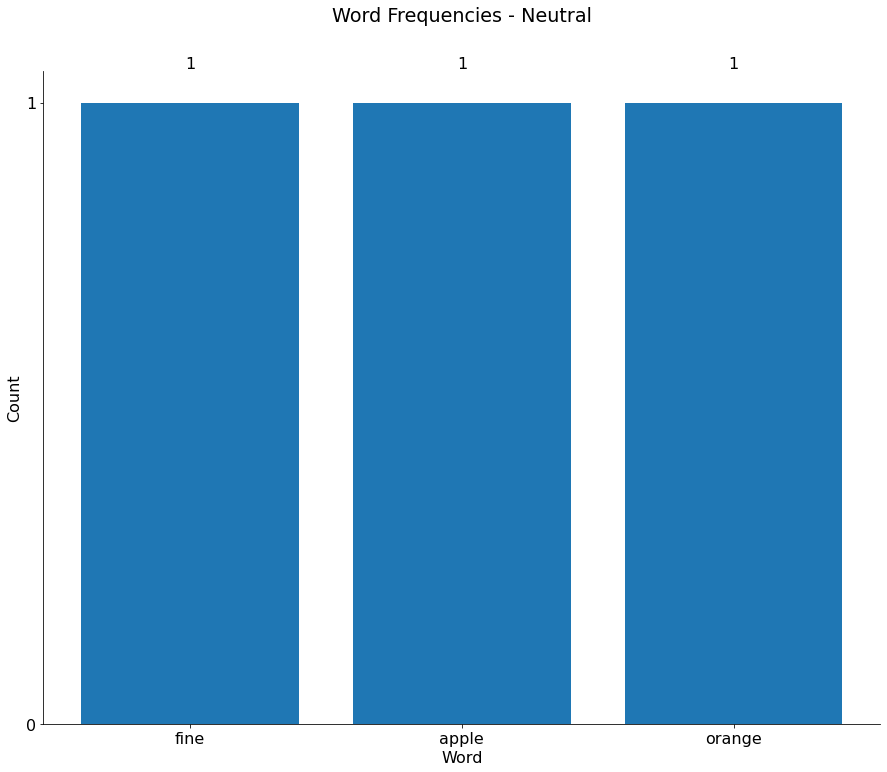

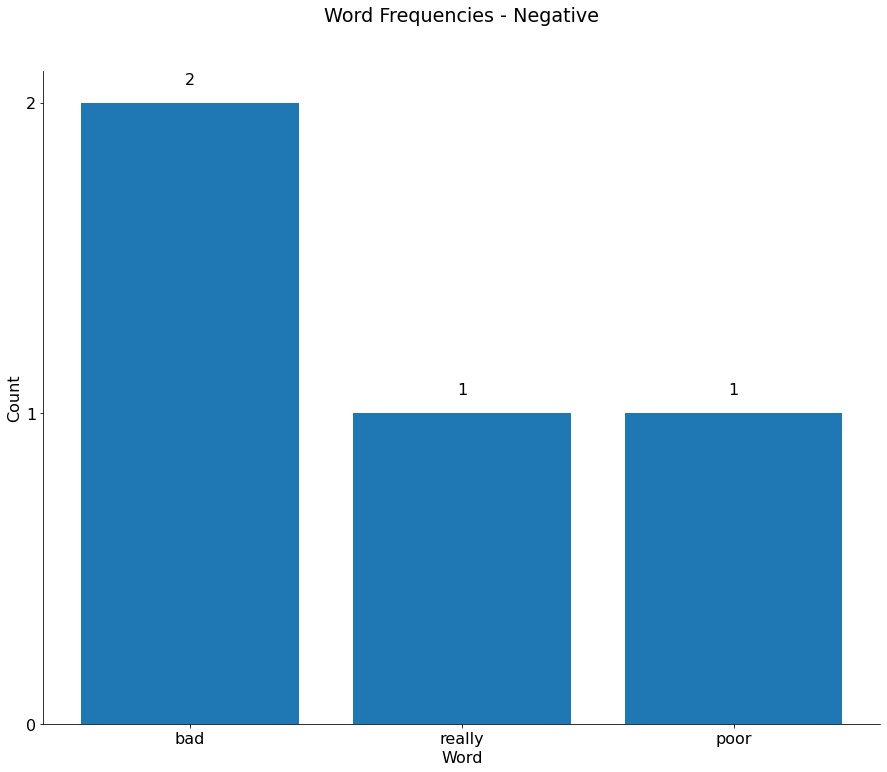

Min: 1
Max: 8
Total: 49


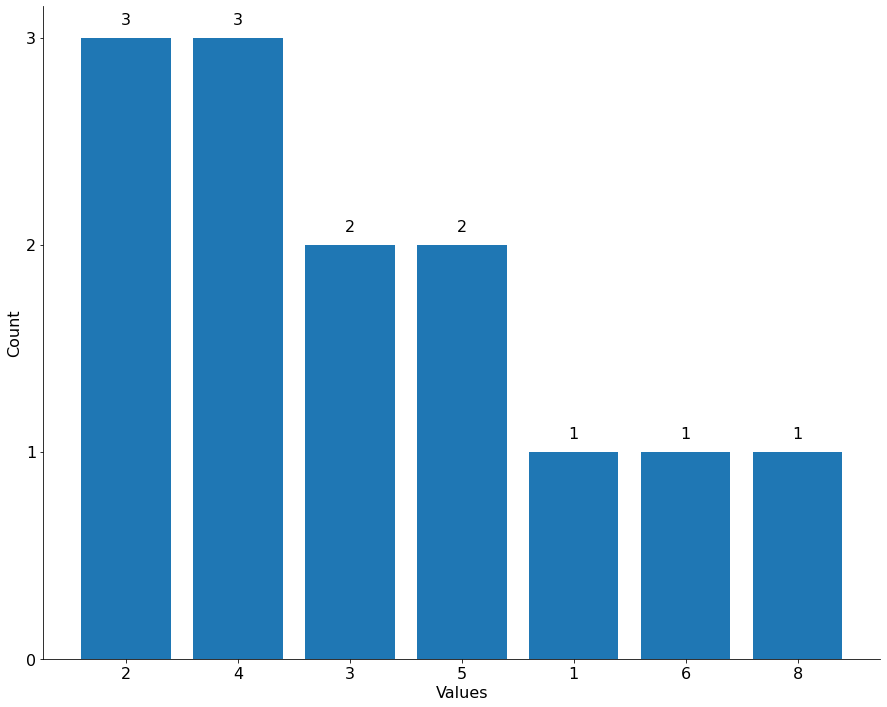

In [129]:
xl = pd.ExcelFile(DATASET)
df = xl.parse(DATASET_SHEET)
xl = pd.ExcelFile(QUESTION_DEFINITIONS)
qd = xl.parse(QUESTION_DEFINITIONS_SHEET)

if Path('results').is_dir() == False:
    Path("results").mkdir(parents=True, exist_ok=True)


question_count = 0
for index, row in qd.iterrows():
    question = row["Question"]
    question_type = row["Type"]
    question_count += 1
    html_print("<h3>Q" + str(question_count) + ": " + question + "</h3>")
    html_print("<hr/>")
    if question_type == "sc":
        grpby = df.groupby(question)[question].count()
        x,y = zip(*process_tuples(grpby.items()))
        create_graph(x, y, "", "Values", "Count", "bar")
    elif question_type == "mc":
        obj = {}
        for row in df[question]:
            selected_options = str(row).split(";")
            for option in selected_options:
                if option not in obj.keys():
                    obj[option] = 1
                else:
                    obj[option] += 1
        x, y = zip(*process_tuples(obj.items()))
        create_graph(x, y, "", "Values", "Count", "bar")
    elif question_type == "int":
        grpby = df.groupby(question)[question].count()
        print("Min: " + str(df[question].min()))
        print("Max: " + str(df[question].max()))
        print("Total: " + str(df[question].sum()))
        x,y = zip(*process_tuples(grpby.items()))
        x = list(map(str, x)) # Need to convert all integers to string for the sorting in the graph to work properly
        create_graph(x, y, "", "Values", "Count", "bar")
    elif question_type == "txt":
        sa = SentimentIntensityAnalyzer()
        pos_list = []
        neg_list = []
        neu_list = []
        consolidated_data = {"Text": [], "Sentiment": [], "Score": [], "ContainWordsWithHighFrequencies": []}
        
        # Sentiment Analysis and Sorting of Text
        for row in df[question]:
            sa_result = sa.polarity_scores(row)
            pos, neg, neu = itemgetter('pos', 'neg', 'neu')(sa_result)
            consolidated_data["Text"].append(row)
            if pos > neg + neu:
                pos_list.append(row)
                consolidated_data["Sentiment"].append("Positive")
                consolidated_data["Score"].append(pos)
            elif neg > pos + neu:
                neg_list.append(row)
                consolidated_data["Sentiment"].append("Negative")
                consolidated_data["Score"].append(neg)
            else:
                neu_list.append(row)
                consolidated_data["Sentiment"].append("Neutral")
                consolidated_data["Score"].append(neu)
        
        # Highlighting the words with high frequencies
        x = ["Postive", "Neutral", "Negative"]
        y = [len(pos_list), len(neu_list), len(neg_list)]
        create_graph(x, y, "Number of Responses by Sentiments", "Sentiments", "Count", "bar")
        pos_wf = word_frequencies(generate_word_list(" ".join(pos_list)))
        word_frequency_graph(pos_wf, "Word Frequencies - Positive")
        print("\n")
        neu_wf = word_frequencies(generate_word_list(" ".join(neu_list)))
        word_frequency_graph(neu_wf, "Word Frequencies - Neutral")
        print("\n")
        neg_wf = word_frequencies(generate_word_list(" ".join(neg_list)))
        word_frequency_graph(neg_wf, "Word Frequencies - Negative")
        
        # Tag text if they contain words with high frequencies
        index = -1
        for row in consolidated_data["Text"]:
            index += 1
            if consolidated_data["Sentiment"][index] == "Positive":
                wf = pos_wf
            elif consolidated_data["Sentiment"][index] == "Negative":
                wf = neg_wf
            elif consolidated_data["Sentiment"][index] == "Neutral":
                wf = neu_wf
            
            containWordsWithHighFrequencies = ""
            text_lowercase = row.lower()
            for w in wf:
                if w[0] in text_lowercase:
                    if containWordsWithHighFrequencies != "":
                        containWordsWithHighFrequencies += ", " + w[0]
                    else:
                        containWordsWithHighFrequencies = w[0]
            if containWordsWithHighFrequencies != "":
                consolidated_data["ContainWordsWithHighFrequencies"].append(containWordsWithHighFrequencies)
            else:
                consolidated_data["ContainWordsWithHighFrequencies"].append("-")
        
        # Store results in a Excel spreadsheet
        sentiment_df = pd.DataFrame(data=consolidated_data)
        sentiment_df.to_excel("results\Q" + str(question_count) + ".xlsx", index=False)
        
    print("\n")